# A/B Test: Did moving the in-game gate from level 30 → level 40 change retention?
**Dataset:** Cookie Cats (columns: `userid`, `version` (gate_30 / gate_40), `sum_gamerounds`, `retention_1`, `retention_7`)  
**Goal:** Test if the proportion of players retained at day 1 and day 7 changed when the gate was moved from level 30 to level 40.

**Plan**
1. Load and clean the data.
2. State hypotheses and justify test choice.
3. Run two-proportion z-tests for retention_1 and retention_7.
4. Compute 95% CI for the difference in proportions.
5. Visualize and provide recommendation.


In [25]:
import os
import pandas as pd
import numpy as np
from scipy import stats

from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt


In [26]:

df = pd.read_csv('cookie_cats.csv')


print(df.head(10))
print(' ')

print('shape is : ', df.shape)

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
6    1066  gate_30               0        False        False
7    1444  gate_40               2        False        False
8    1574  gate_40             108         True         True
9    1587  gate_40             153         True        False
 
shape is :  (90189, 5)


## Hypotheses and test choice

For each retention metric (retention_1 and retention_7):

- **Null hypothesis (H0):** The proportion retained under `gate_30` equals the proportion retained under `gate_40`.
  - H0: p_30 = p_40

- **Alternative hypothesis (H1):** The proportions are different (two-sided).
  - H1: p_30 ≠ p_40

**Test choice justification**
- We compare proportions from two independent groups (players assigned to `gate_30` vs `gate_40`).
- Sample sizes are large (expected in product A/B datasets). The two-proportion z-test is appropriate when n*p and n*(1-p) are reasonably large (rule of thumb: ≥5).
- We'll report z statistic, two-sided p-value, and a 95% confidence interval for the difference p_30 - p_40.


In [27]:
#normalization
df['version'] = df['version'].astype(str).str.strip().str.lower()

In [28]:
df[['retention_1', 'retention_7']] = df[['retention_1', 'retention_7']].astype(bool)

print(df['retention_1'].value_counts())
print(' ')
print(df['retention_7'].value_counts())
print(' ')
print(df['version'].value_counts())
print(' ')





retention_1
False    50036
True     40153
Name: count, dtype: int64
 
retention_7
False    73408
True     16781
Name: count, dtype: int64
 
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64
 


In [29]:
# Cell 2: compute counts and proportions for one group
def group_stats(df, group_col, outcome_col, group_label):
    """
    Returns (n, x, p) for rows where df[group_col] == group_label.
    n = sample size, x = count of successes (True), p = proportion x/n
    """
    g = df[df[group_col] == group_label]
    n = len(g)
    if n == 0:
        raise ValueError(f"No observations for group '{group_label}'.")
    x = int(g[outcome_col].sum())
    p = x / n
    return n, x, p


In [30]:
# Cell 3: run two-proportion z-test (uses pooled estimate under H0)
def run_two_proportion_ztest(x1, n1, x2, n2, alternative='two-sided'):
    """
    Returns (zstat, pval) using statsmodels.proportions_ztest.
    """
    count = np.array([x1, x2])
    nobs  = np.array([n1, n2])
    zstat, pval = proportions_ztest(count, nobs, alternative=alternative)
    return float(zstat), float(pval)


In [31]:
# Cell 4: compute CI for p1 - p2 using unpooled (observed) standard error
def diff_confidence_interval(p1, p2, n1, n2, alpha=0.05):
    """
    Returns (diff, se, ci_lower, ci_upper)
    where diff = p1 - p2
    """
    diff = p1 - p2
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z_crit = stats.norm.ppf(1 - alpha/2)
    ci_lower = diff - z_crit * se
    ci_upper = diff + z_crit * se
    return float(diff), float(se), float(ci_lower), float(ci_upper)


In [32]:
# Cell 5: wrapper that calls the helpers and returns a concise dict
def two_proportion_test(df, group_col, outcome_col, group_a='gate_30', group_b='gate_40', alpha=0.05):
    n1, x1, p1 = group_stats(df, group_col, outcome_col, group_a)
    n2, x2, p2 = group_stats(df, group_col, outcome_col, group_b)

    zstat, pval = run_two_proportion_ztest(x1, n1, x2, n2, alternative='two-sided')
    diff, se, ci_lower, ci_upper = diff_confidence_interval(p1, p2, n1, n2, alpha=alpha)

    return {
        'outcome': outcome_col,
        'group_a': group_a, 'n1': n1, 'x1': x1, 'p1': p1,
        'group_b': group_b, 'n2': n2, 'x2': x2, 'p2': p2,
        'zstat': zstat, 'pval': pval,
        'diff_p1_p2': diff, 'se_diff': se,
        'ci_lower': ci_lower, 'ci_upper': ci_upper
    }

# Example: run for retention_1 and display
res_r1 = two_proportion_test(df, 'version', 'retention_1', group_a='gate_30', group_b='gate_40')
res_r1


{'outcome': 'retention_1',
 'group_a': 'gate_30',
 'n1': 44700,
 'x1': 20034,
 'p1': 0.4481879194630872,
 'group_b': 'gate_40',
 'n2': 45489,
 'x2': 20119,
 'p2': 0.44228274967574577,
 'zstat': 1.7840862247974725,
 'pval': 0.07440965529691913,
 'diff_p1_p2': 0.005905169787341458,
 'se_diff': 0.003309892280304391,
 'ci_lower': -0.0005820998747623016,
 'ci_upper': 0.012392439449445217}

In [33]:
# Cell 6: Run both tests and create a summary table
res_r1 = two_proportion_test(df, 'version', 'retention_1', group_a='gate_30', group_b='gate_40')
res_r7 = two_proportion_test(df, 'version', 'retention_7', group_a='gate_30', group_b='gate_40')

summary = pd.DataFrame([res_r1, res_r7])

summary


,outcome,group_a,n1,x1,p1,group_b,n2,x2,p2,zstat,pval,diff_p1_p2,se_diff,ci_lower,ci_upper
0,retention_1,gate_30,44700,20034,0.448188,gate_40,45489,20119,0.442283,1.784086,0.074410,0.005905,0.003310,-0.000582,0.012392
1,retention_7,gate_30,44700,8502,0.190201,gate_40,45489,8279,0.182000,3.164359,0.001554,0.008201,0.002592,0.003121,0.013282


## How to interpret the outputs

For each outcome:
- `n1`, `x1`, `p1` are sample size, successes and observed proportion for `gate_30`.
- `n2`, `x2`, `p2` are the same for `gate_40`.
- `zstat` and `pval` are from the two-proportion z-test (two-sided).
  - If `pval < 0.05` (α=0.05) → reject H0 and conclude a statistically significant difference.
  - If `pval >= 0.05` → do not reject H0; no statistically significant evidence of a difference.
- `diff_p1_p2 = p1 - p2`. Positive means retention higher in `gate_30`, negative means higher in `gate_40`.
- `ci_lower`/`ci_upper` gives the 95% CI for `p1 - p2`. If CI includes 0, the difference is not statistically significant at 95% level.


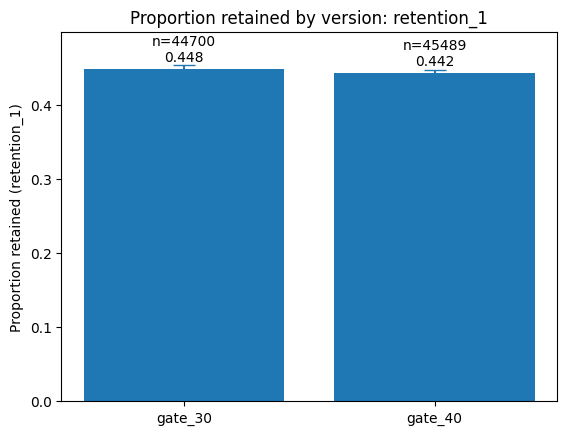

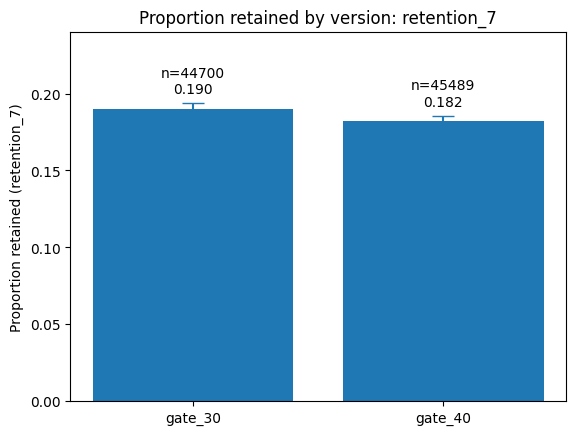

In [34]:
# Cell 8: Bar plot of proportions with 95% CI error bars (for both retention_1 and retention_7)

def plot_prop_with_ci(df, outcome_col, group_col='version', groups=['gate_30','gate_40']):
    stats_list = []
    for g in groups:
        d = df[df[group_col] == g]
        n = len(d)
        x = d[outcome_col].sum()
        p = x / n
        # approximate 95% CI for single proportion (Wilson or normal approx) -> use normal approx here:
        se = np.sqrt(p*(1-p)/n)
        z = stats.norm.ppf(0.975)
        ci_low = p - z*se
        ci_hi  = p + z*se
        stats_list.append({'group': g, 'p': p, 'ci_low': ci_low, 'ci_hi': ci_hi, 'n': n})
    stats_df = pd.DataFrame(stats_list)

    fig, ax = plt.subplots()
    ax.bar(stats_df['group'], stats_df['p'])
    ax.errorbar(stats_df['group'], stats_df['p'], yerr=[stats_df['p'] - stats_df['ci_low'], stats_df['ci_hi'] - stats_df['p']],
                fmt='none', capsize=8)
    ax.set_ylim(0, min(1, stats_df['p'].max() + 0.05))
    ax.set_ylabel(f'Proportion retained ({outcome_col})')
    ax.set_title(f'Proportion retained by version: {outcome_col}')
    for i, r in stats_df.iterrows():
        ax.text(i, r['p'] + 0.01, f"n={r['n']}\n{r['p']:.3f}", ha='center')
    plt.show()

# Plot for retention_1 and retention_7
plot_prop_with_ci(df, 'retention_1')
plot_prop_with_ci(df, 'retention_7')


## Automated interpretation (based on the computed p-values)

- If **p < 0.05** for a retention metric → there is a statistically significant difference between `gate_30` and `gate_40` for that metric.
  - Check the sign of `diff_p1_p2`:
    - If `diff_p1_p2 > 0` → `gate_30` had higher retention.
    - If `diff_p1_p2 < 0` → `gate_40` had higher retention.
  - Also look at the magnitude of the difference and confidence interval to judge practical significance (is the change large enough to matter?).

- If **p >= 0.05** → no evidence of a difference at the 5% level; consider either keeping the current gate or running a larger experiment if a smaller effect size is important.

Below is a small code cell that prints a plain-language recommendation using the results we computed.


## Power / sample-size note & next steps

- If you fail to detect a statistically significant difference but care about small effects, run a **power analysis** to estimate the sample size required to detect a minimum practically important difference (e.g., +1 percentage point).
- Also check for:
  - **randomization balance**: Are other covariates balanced across versions? (e.g., device, country).
  - **segmented effects**: Maybe the gate change affects new players differently than returning players — try cohort/segment analysis.
  - **business metrics**: retention is important but weigh it vs. revenue, engagement, level completion rates, and player experience/complaints.


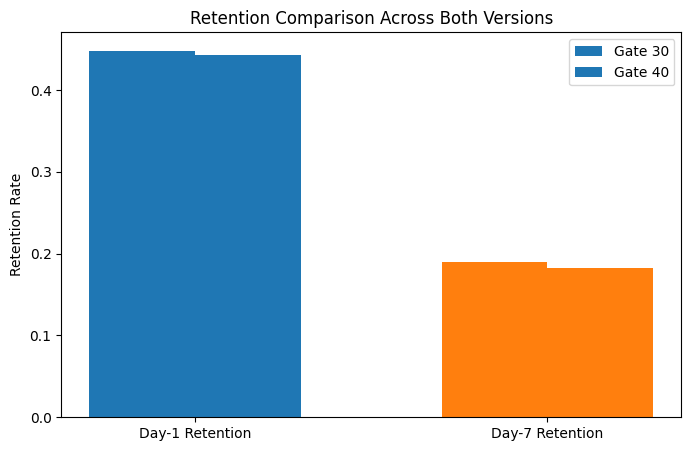

In [35]:
# ------------------- VISUAL 1: SIDE-BY-SIDE GROUP RETENTION COMPARISON -------------------

metrics = ['retention_1', 'retention_7']
groups = ['gate_30', 'gate_40']

plot_data = []
for metric in metrics:
    for g in groups:
        subset = df[df['version'] == g]
        p = subset[metric].mean()
        plot_data.append([metric, g, p])
        
plot_df = pd.DataFrame(plot_data, columns=['metric','group','proportion'])

fig, ax = plt.subplots(figsize=(8,5))
for i, metric in enumerate(metrics):
    subset = plot_df[plot_df['metric']==metric]
    ax.bar([i-0.15, i+0.15], subset['proportion'], width=0.3, 
           label=subset['group'].tolist() if i==0 else "")

ax.set_xticks(range(len(metrics)))
ax.set_xticklabels(['Day-1 Retention','Day-7 Retention'])
ax.set_ylabel('Retention Rate')
ax.set_title('Retention Comparison Across Both Versions')
ax.legend(['Gate 30','Gate 40'])
plt.show()


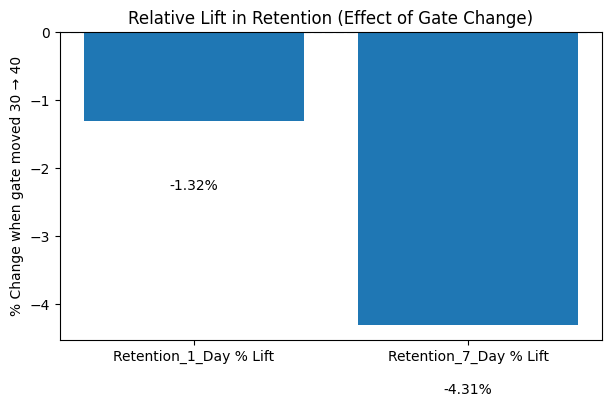

In [36]:
# ------------------- VISUAL 2: RELATIVE LIFT PLOT -------------------

lift = {
    'Retention_1_Day % Lift': (res_r1['p2'] - res_r1['p1']) / res_r1['p1'] * 100,
    'Retention_7_Day % Lift': (res_r7['p2'] - res_r7['p1']) / res_r7['p1'] * 100
}

lift_df = pd.DataFrame(lift.items(), columns=['Metric','% Lift'])

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(lift_df['Metric'], lift_df['% Lift'])
ax.axhline(0, linestyle='--')
ax.set_ylabel('% Change when gate moved 30 → 40')
ax.set_title('Relative Lift in Retention (Effect of Gate Change)')
for i,val in enumerate(lift_df['% Lift']):
    ax.text(i, val+ (1 if val>0 else -1), f"{val:.2f}%", ha='center')
plt.show()


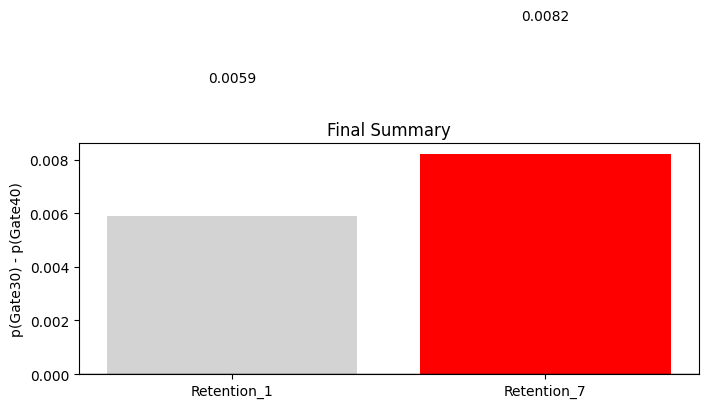


FINAL SUMMARY TABLE:



,Metric,Gate_30,Gate_40,Difference (p30-p40),P-Value
0,Retention_1,0.448188,0.442283,0.005905,0.074410
1,Retention_7,0.190201,0.182000,0.008201,0.001554


In [37]:
# ------------------- VISUAL 3: FINAL SUMMARY HEATMAP -------------------

final_summary = pd.DataFrame({
    'Metric':['Retention_1','Retention_7'],
    'Gate_30': [res_r1['p1'], res_r7['p1']],
    'Gate_40': [res_r1['p2'], res_r7['p2']],
    'Difference (p30-p40)': [res_r1['diff_p1_p2'], res_r7['diff_p1_p2']],
    'P-Value':[res_r1['pval'], res_r7['pval']]
})

# Color coding based on improvement/worsening
def color_eval(row):
    if row['P-Value']<0.05 and row['Difference (p30-p40)']<0:
        return 'green'   # retention improved
    elif row['P-Value']<0.05 and row['Difference (p30-p40)']>0:
        return 'red'     # retention dropped
    return 'lightgrey'   # not significant

colors = final_summary.apply(color_eval, axis=1)

fig, ax = plt.subplots(figsize=(8,3))
ax.bar(final_summary['Metric'], final_summary['Difference (p30-p40)'], 
       color=colors)
ax.axhline(0,color='black',linewidth=1)

ax.set_ylabel("p(Gate30) - p(Gate40)")
ax.set_title("Final Summary")
for i,val in enumerate(final_summary['Difference (p30-p40)']):
    ax.text(i,val+(0.005 if val>0 else -0.005),f"{val:.4f}",ha='center')
plt.show()

print("\nFINAL SUMMARY TABLE:\n")
display(final_summary)
